In [1]:
import time
from typing import List, Dict

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import math
from timm.models.layers import trunc_normal_

import matplotlib.pyplot as plt

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


[INFO] Couldn't find torchinfo... installing it.


In [2]:
# Set all seeds for reproducibility
import random
import os

def set_seed(seed=42):
    # Python
    random.seed(seed)
    # PyTorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # For multi-GPU setups
    # Environment variables (for CUDA)
    os.environ["PYTHONHASHSEED"] = str(seed)
    # PyTorch deterministic mode (may impact performance)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [3]:
print(f'Can I can use GPU now? -- {torch.cuda.is_available()}')

Can I can use GPU now? -- True


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [17]:
def train(model: nn.Module,
          loss_fn: nn.modules.loss._Loss,
          optimizer: torch.optim.Optimizer,
          train_loader: torch.utils.data.DataLoader,
          epoch: int=0,
          scheduler=None,
          device=device)-> List: # Add device argument
    # ----------- <Your code> ---------------


    model.train()
    train_loss = []

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)


        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)


        loss.backward()
        optimizer.step()

        if scheduler is not None:
            scheduler.step()

        train_loss.append(loss.item())

        if batch_idx % (len(train_loader) // 10) == 0:
            print(f'Epoch {epoch}: [{batch_idx*len(images)}/{len(train_loader.dataset)}] Loss: {loss.item():.3f}')


    assert len(train_loss) == len(train_loader)
    return train_loss

def test(model: nn.Module,
         loss_fn: nn.modules.loss._Loss,
         test_loader: torch.utils.data.DataLoader,
         epoch: int=0)-> Dict:

    model.eval()
    test_loss = 0
    correct = 0
    total_num = len(test_loader.dataset)
    predictions = []

    with torch.no_grad():
        for images, labels in test_loader:
            # Move data to device
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)

            # Sum up batch loss
            test_loss += loss_fn(outputs, labels).item() * images.size(0)

            # Get predictions
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()

            # Store predictions
            predictions.append(predicted)

    # Concatenate all predictions
    all_predictions = torch.cat(predictions)

    # Calculate average loss
    test_loss /= total_num

    # Calculate accuracy
    accuracy = correct / total_num

    # Create test statistics dictionary
    test_stat = {
        "loss": test_loss,
        "accuracy": accuracy,
        "prediction": all_predictions.cpu()  # Move predictions back to CPU
    }

    # Print log
    print(f"Test result on epoch {epoch}: total sample: {total_num}, Avg loss: {test_stat['loss']:.3f}, Acc: {100*test_stat['accuracy']:.3f}%")


    # dictionary should include loss, accuracy and prediction
    assert "loss" and "accuracy" and "prediction" in test_stat.keys()
    # "prediction" value should be a 1D tensor
    assert len(test_stat["prediction"]) == len(test_loader.dataset)
    assert isinstance(test_stat["prediction"], torch.Tensor)
    return test_stat


100%|██████████| 9.91M/9.91M [00:02<00:00, 4.55MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]
100%|██████████| 1.65M/1.65M [00:06<00:00, 244kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.42MB/s]


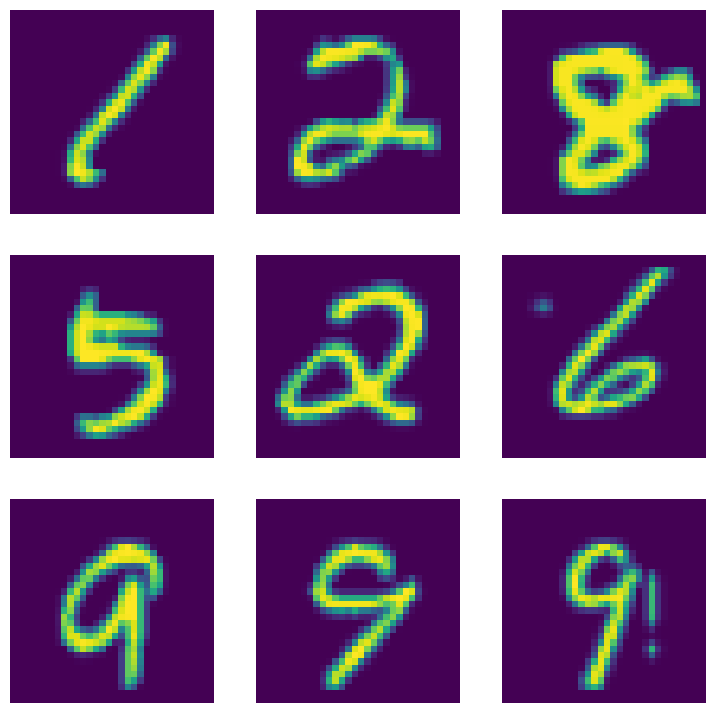

In [8]:
# Download MNIST and transformation
IMG_SIZE = 32
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

test_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)


# Code to display images
batch_idx, (images, targets) = next(enumerate(train_loader)) #fix!!!!!
fig, ax = plt.subplots(3,3,figsize = (9,9))
for i in range(3):
    for j in range(3):
        image = images[i*3+j].permute(1,2,0)
        image = image/2 + 0.5
        ax[i,j].imshow(image)
        ax[i,j].set_axis_off()
fig.show()

In [9]:
images, labels = next(iter(train_loader))

# Check the shape of the entire batch
print("Batch shape:", images.shape)

# Check the shape of the first image in the batch
print("Single image shape:", images[0].shape)

Batch shape: torch.Size([32, 1, 32, 32])
Single image shape: torch.Size([1, 32, 32])


In [ ]:
def create_projection_layers(num_of_words, inner_dim, outer_dim, norm_layer):
    """
    Creates three layers for projection:
    1. First normalization layer
    2. Linear projection layer
    3. Second normalization layer

    Args:
        num_of_words: Number of patches in the inner that consists the outer
        inner_dim: Inner dimension size
        outer_dim: Outer dimension size
        norm_layer: Normalization layer function/class to use

    Returns:
        Tuple of (proj_norm1_last, proj_last, proj_norm2_last)
    """
    normalization_layer = norm_layer(num_of_words * inner_dim)
    projection_layer = nn.Linear(num_of_words * inner_dim, outer_dim, bias=False)
    normalization_layer_after_projection = norm_layer(outer_dim)

    return normalization_layer, projection_layer, normalization_layer_after_projection


# Would be helpful to use if the model is being trained on vert large dataset, for now it's not applied.
class SE(nn.Module):
    def __init__(self, dim, hidden_ratio=None):
        super().__init__()
        hidden_ratio = hidden_ratio or 1
        self.dim = dim
        hidden_dim = int(dim * hidden_ratio)
        self.fc = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, dim),
            nn.Tanh()
        )

    def forward(self, x):
        a = x.mean(dim=1, keepdim=True) # B, 1, C
        a = self.fc(a)
        x = a * x
        return x

# The Attention class is majorly the same as TNT Implementation
# Dropouts is not applied
class Attention(nn.Module):
    def __init__(self, dim, hidden_dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads
        head_dim = hidden_dim // num_heads
        self.head_dim = head_dim
        self.scale = qk_scale or head_dim ** -0.5

        self.qk = nn.Linear(dim, hidden_dim * 2, bias=qkv_bias)
        self.v = nn.Linear(dim, dim, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qk = self.qk(x).reshape(B, N, 2, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k = qk[0], qk[1]
        v = self.v(x).reshape(B, N, self.num_heads, -1).permute(0, 2, 1, 3)

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, -1)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

## The Mlp class layers is majorly the same as the TNT Implementation
# Dropouts is not applied
class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

class Block(nn.Module):
    def __init__(self, outer_dim, outer_num_heads, middle_dim, middle_num_heads, num_words, inner_dim, inner_num_heads, num_letters, #Positional arguments
                 mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0., act_layer=nn.GELU, #keyword arguments
                 norm_layer=nn.LayerNorm, se=0):
        super().__init__()

        # Check if that block should have inner transformer or ignore it
        self.has_inner = inner_dim > 0
        if self.has_inner:
            # Inner
            self.last_norm1 = norm_layer(inner_dim)
            self.last_attn = Attention(
                inner_dim, inner_dim, num_heads=inner_num_heads, qkv_bias=qkv_bias,
                qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)

            self.last_norm2 = norm_layer(inner_dim)
            self.last_mlp = Mlp(in_features=inner_dim, hidden_features=int(inner_dim * mlp_ratio),
                                 out_features=inner_dim, act_layer=act_layer, drop=drop)


            # Create layers that will be used to project the inner embedding on the middle embedding
            self.inner_tokens_proj_norm1, self.inner_tokens_proj, self.inner_tokens_proj_norm2 = create_projection_layers(num_letters, inner_dim, middle_dim, norm_layer)

        # Check if that block should have a middle transformer or ignore it
        self.has_middle = middle_dim > 0
        if self.has_middle:
            # Middle
            self.middle_norm1 = norm_layer(middle_dim)
            self.middle_attn = Attention(
                middle_dim, middle_dim, num_heads=middle_num_heads, qkv_bias=qkv_bias,
                qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)

            self.middle_norm2 = norm_layer(middle_dim)
            self.middle_mlp = Mlp(in_features=middle_dim, hidden_features=int(middle_dim * mlp_ratio),
                                 out_features=middle_dim, act_layer=act_layer, drop=drop)

            # Create layers that will be used to project the middle embedding to the outer embedding
            self.middle_tokens_proj_norm1, self.middle_tokens_proj, self.middle_tokens_proj_norm2 = create_projection_layers(num_words, middle_dim, outer_dim, norm_layer)


        # Outer
        self.outer_norm1 = norm_layer(outer_dim)
        self.outer_attn = Attention(
            outer_dim, outer_dim, num_heads=outer_num_heads, qkv_bias=qkv_bias,
            qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)

        self.outer_norm2 = norm_layer(outer_dim)
        self.outer_mlp = Mlp(in_features=outer_dim, hidden_features=int(outer_dim * mlp_ratio),
                             out_features=outer_dim, act_layer=act_layer, drop=drop)


        # SE
        self.se = se
        self.se_layer = None
        if self.se > 0:
            self.se_layer = SE(outer_dim, 0.25 ) #Ratio of TNT


    def forward(self, inner_tokens, middle_tokens, outer_tokens):
        if self.has_inner:
            inner_tokens = inner_tokens + self.last_attn(self.last_norm1(inner_tokens)) # B*N*M, s*s, ci
            inner_tokens = inner_tokens + self.last_mlp(self.last_norm2(inner_tokens)) # B*N*M, s*s, ci
            BN, M, cm = middle_tokens.size()
            # Concatenate the inner embeddings then project on middle embeddings
            middle_tokens = middle_tokens + self.inner_tokens_proj_norm2(self.inner_tokens_proj(self.inner_tokens_proj_norm1(inner_tokens.reshape(BN, M, -1)))) # B*N, M, cm
        if self.has_middle:
            middle_tokens = middle_tokens + self.middle_attn(self.middle_norm1(middle_tokens)) # B*N, k*k, c
            middle_tokens = middle_tokens + self.middle_mlp(self.middle_norm2(middle_tokens)) # B*N, k*k, c
            B, N, C = outer_tokens.size()
            # Concatenate the middle embeddings then project on outer embeddings (NOTE that the array slice is due to the class token)
            outer_tokens[:,1:] = outer_tokens[:,1:] + self.middle_tokens_proj_norm2(self.middle_tokens_proj(self.middle_tokens_proj_norm1(middle_tokens.reshape(B, N-1, -1)))) # B, N, C
        if self.se > 0:
            outer_tokens = outer_tokens + self.outer_attn(self.outer_norm1(outer_tokens))
            tmp_outer_tokens = self.outer_mlp(self.outer_norm2(outer_tokens))
            outer_tokens = outer_tokens + tmp_outer_tokens + self.se_layer(tmp_outer_tokens)
        else:
            outer_tokens = outer_tokens + self.outer_attn(self.outer_norm1(outer_tokens))
            outer_tokens = outer_tokens + self.outer_mlp(self.outer_norm2(outer_tokens))
        return inner_tokens, middle_tokens, outer_tokens

class PatchEmbed(nn.Module):
    def __init__(self, img_size=32, patch_size=8, in_chans=3, outer_dim=96, inner_dim=24, inner_stride=4, last_dim=6, last_stride=2):
        super().__init__()

        # Various quantities that help in managing dimensionality across the model
        self.img_size = img_size
        self.patch_size = patch_size
        num_patches = math.ceil(self.img_size // patch_size) * math.ceil(self.img_size // patch_size)
        self.num_patches = num_patches
        self.inner_dim = inner_dim
        self.last_dim = last_dim
        self.num_words = math.ceil(patch_size / inner_stride) * math.ceil(patch_size / inner_stride)
        self.num_letters = math.ceil(inner_stride / last_stride) * math.ceil(inner_stride / last_stride)
        inner_size = inner_stride
        self.inner_size = inner_size

        self.unfold = nn.Unfold(kernel_size=patch_size, stride=self.patch_size)
        #self.proj_inner = nn.Conv2d(in_chans, last_dim, kernel_size=3, padding=1, stride=last_stride)
        self.proj_inner = nn.Conv2d(in_chans, last_dim, kernel_size=1, padding=0, stride=last_stride)

    def forward(self, x):
        B, C, H, W = x.shape
        assert H == self.img_size and W == self.img_size, \
            f"Input image size ({H}*{W}) doesn't match model ({self.img_size}*{self.img_size})."
        #Do patch splits till we get letter embeddings, and apply conv2d to extract image features
        x = self.unfold(x) # B, Ck2, N
        x = x.transpose(1, 2)
        x = x.reshape(B * self.num_patches * self.num_words, C, self.inner_size, self.inner_size) # B*N*M, C, r, r
        x = self.proj_inner(x) # B*N*M, ci, r, r
        x = x.reshape(B * self.num_patches * self.num_words, self.last_dim, -1)
        x = x.transpose(1, 2) # B*N*M, r*r, ci
        return x

class RTNT(nn.Module):
    def __init__(self, img_size=32, patch_size=8, in_chans=1, num_classes=10, outer_dim=96, inner_dim=24,
                 depth=12, outer_num_heads=3, inner_num_heads=2, mlp_ratio=4., qkv_bias=False, qk_scale=None,
                 drop_rate=0., attn_drop_rate=0., norm_layer=nn.LayerNorm, inner_stride=4, se=0,
                 last_dim=6, last_stride=2, last_num_heads=1):
        super().__init__()
        self.num_classes = num_classes
        self.num_features = self.outer_dim = outer_dim

        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=in_chans, outer_dim=outer_dim,
            inner_dim=inner_dim, inner_stride=inner_stride, last_dim=last_dim, last_stride=last_stride)

        # Qunatities that control dimensionality across the model
        self.num_patches = num_patches = self.patch_embed.num_patches
        self.num_words = num_words = self.patch_embed.num_words
        self.num_letters = num_letters = self.patch_embed.num_letters

        # Classfication tokens
        self.cls_token = nn.Parameter(torch.zeros(1, 1, outer_dim))

        #i Intializations for outer abd middle tokens, all set to zeros
        self.outer_tokens = nn.Parameter(torch.zeros(1, num_patches, outer_dim), requires_grad=False)
        self.inner_tokens = nn.Parameter(torch.zeros(num_patches, num_words, inner_dim), requires_grad=False)

        # Positional embeddings
        self.outer_pos = nn.Parameter(torch.zeros(1, num_patches + 1, outer_dim))
        self.inner_pos = nn.Parameter(torch.zeros(1, num_words, inner_dim))
        self.last_pos = nn.Parameter(torch.zeros(1, num_letters, last_dim))

        self.pos_drop = nn.Dropout(p=drop_rate)

        # Layers to help projecting letter/word embedding on word/sentence embeddings
        self.middle_tokens_proj_norm1, self.middle_tokens_proj, self.middle_tokens_proj_norm2 = create_projection_layers(num_words, inner_dim, outer_dim, norm_layer)
        self.inner_tokens_proj_norm1, self.inner_tokens_proj, self.inner_tokens_proj_norm2 = create_projection_layers(num_letters, last_dim, inner_dim, norm_layer)


        #Yoy can control which layers include the inner transformer so to mimic TNT using this model
        vanilla_idxs = []
        blocks = []
        for i in range(depth):



            if i in vanilla_idxs:
                blocks.append(Block(
                    outer_dim=outer_dim, outer_num_heads=outer_num_heads, middle_dim=inner_dim, middle_num_heads=inner_num_heads,
                    num_words=num_words, inner_dim=-1, innet_num_heads=last_num_heads, num_letters=num_letters,
                    mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale, drop=drop_rate,
                    attn_drop=attn_drop_rate, norm_layer=norm_layer, se=se))
            else:
                blocks.append(Block(
                    outer_dim=outer_dim, outer_num_heads=outer_num_heads, middle_dim=inner_dim, middle_num_heads=inner_num_heads,
                    num_words=num_words, inner_dim=last_dim, inner_num_heads=last_num_heads, num_letters=num_letters,
                    mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale, drop=drop_rate,
                    attn_drop=attn_drop_rate, norm_layer=norm_layer, se=se))

        self.blocks = nn.ModuleList(blocks)
        self.norm = norm_layer(outer_dim)

        # Classifier head
        self.head = nn.Linear(outer_dim, num_classes) if num_classes > 0 else nn.Identity()

    def forward_features(self, x):
        B = x.shape[0]
        last_tokens = self.patch_embed(x) + self.last_pos

        # Set the inner and outer tokens with image data instead of zeros/normal distripution
        inner_tokens = self.inner_tokens_proj_norm2(self.inner_tokens_proj(self.inner_tokens_proj_norm1(last_tokens.reshape(B*self.num_patches, self.num_words, -1)))) + self.inner_pos # B*N, s*s, c
        outer_tokens = self.middle_tokens_proj_norm2(self.middle_tokens_proj(self.middle_tokens_proj_norm1(inner_tokens.reshape(B, self.num_patches, -1)))) # B, p*p, C

        outer_tokens = torch.cat((self.cls_token.expand(B, -1, -1), outer_tokens), dim=1)
        outer_tokens = outer_tokens + self.outer_pos
        outer_tokens = self.pos_drop(outer_tokens)

        for blk in self.blocks:
            last_tokens, inner_tokens, outer_tokens = blk(last_tokens, inner_tokens, outer_tokens)

        outer_tokens = self.norm(outer_tokens)
        return outer_tokens[:, 0]

    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)
        return x

    # Class Methods
    def get_classifier(self):
        return self.head

    def reset_classifier(self, num_classes, global_pool=''):
        self.num_classes = num_classes
        self.head = nn.Linear(self.outer_dim, num_classes) if num_classes > 0 else nn.Identity()

In [15]:
rtnt = RTNT(num_classes=10)

demo_img = torch.randn(1, 1, 32, 32).to(device)
print(demo_img.shape)

summary(model=rtnt,
        input_size=demo_img.shape)

torch.Size([1, 1, 32, 32])


Layer (type:depth-idx)                   Output Shape              Param #
RTNT                                     [1, 10]                   4,920
├─PatchEmbed: 1-1                        [64, 4, 6]                --
│    └─Unfold: 2-1                       [1, 64, 16]               --
│    └─Conv2d: 2-2                       [64, 6, 2, 2]             12
├─LayerNorm: 1-2                         [16, 4, 24]               48
├─Linear: 1-3                            [16, 4, 24]               576
├─LayerNorm: 1-4                         [16, 4, 24]               48
├─LayerNorm: 1-5                         [1, 16, 96]               192
├─Linear: 1-6                            [1, 16, 96]               9,216
├─LayerNorm: 1-7                         [1, 16, 96]               192
├─Dropout: 1-8                           [1, 17, 96]               --
├─ModuleList: 1-9                        --                        --
│    └─Block: 2-3                        [64, 4, 6]                --
│    │

In [25]:
# Let's first train the FC model. Below are there common hyperparameters.
criterion = nn.CrossEntropyLoss()

start = time.time()
max_epoch = 5
# ----------- <Your code> ---------------
# Initialize FC model and move to device
net2 = RTNT().to(device)
optimizer = optim.Adam(net2.parameters(), lr=0.001)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.97)

all_train_losses = []
# Train for max_epoch epochs
for epoch in range(1, max_epoch + 1):
    # Train
    train_loss = train(net2, criterion, optimizer, train_loader, epoch, scheduler)
    all_train_losses.extend(train_loss)
    # Test
    test_stat = test(net2, criterion, test_loader, epoch)

    print(f'Epoch {epoch} finished with accuracy: {100*test_stat["accuracy"]:.2f}%')


# ----------- <End Your code> ---------------
end = time.time()
print(f'Finished Training after {end-start} s ')

Epoch 1: [0/60000] Loss: 2.222
Epoch 1: [5984/60000] Loss: 2.226
Epoch 1: [11968/60000] Loss: 1.377
Epoch 1: [17952/60000] Loss: 0.889
Epoch 1: [23936/60000] Loss: 0.679
Epoch 1: [29920/60000] Loss: 0.442
Epoch 1: [35904/60000] Loss: 0.922
Epoch 1: [41888/60000] Loss: 0.351
Epoch 1: [47872/60000] Loss: 0.157
Epoch 1: [53856/60000] Loss: 0.111
Epoch 1: [59840/60000] Loss: 0.567
Test result on epoch 1: total sample: 10000, Avg loss: 0.296, Acc: 90.910%
Epoch 1 finished with accuracy: 90.91%
Epoch 2: [0/60000] Loss: 0.109
Epoch 2: [5984/60000] Loss: 0.410
Epoch 2: [11968/60000] Loss: 0.309
Epoch 2: [17952/60000] Loss: 0.319
Epoch 2: [23936/60000] Loss: 0.239
Epoch 2: [29920/60000] Loss: 0.068
Epoch 2: [35904/60000] Loss: 0.359
Epoch 2: [41888/60000] Loss: 0.380
Epoch 2: [47872/60000] Loss: 0.247
Epoch 2: [53856/60000] Loss: 0.114
Epoch 2: [59840/60000] Loss: 0.390
Test result on epoch 2: total sample: 10000, Avg loss: 0.185, Acc: 94.050%
Epoch 2 finished with accuracy: 94.05%
Epoch 3: [0/

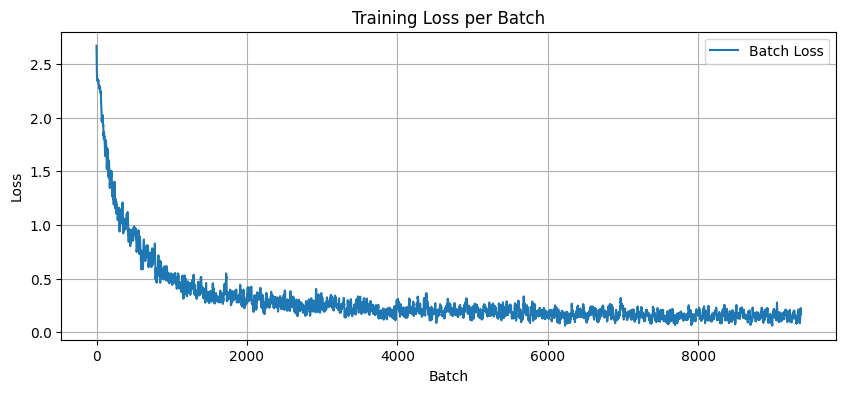

In [22]:
import matplotlib.pyplot as plt
import numpy as np

def moving_average(data, window_size=20):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

smoothed_losses = moving_average(all_train_losses, window_size=10)
# For batch-wise plot
plt.figure(figsize=(10, 4))
plt.plot(smoothed_losses, label='Batch Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Training Loss per Batch')
plt.legend()
plt.grid(True)
plt.show()